# DEA Intertidal Elevation validation

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [2]:
# pip install -r requirements.in --quiet

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import datacube
import rioxarray
import odc.geo.xr
import matplotlib.pyplot as plt
from rasterio.features import sieve
from odc.algo import mask_cleanup
from datacube.testutils.io import rio_slurp_xarray

from intertidal.validation import eval_metrics, map_raster, preprocess_validation

### Load modelled and validation data

In [4]:
# Load LIDAR validation data
validation_ds = rioxarray.open_rasterio("data/raw/lidar_10m.tif", masked=True).squeeze(
    "band"
)
validation_ds.name = "validation_ds"

In [5]:
# Load modelled elevation data from S3
modelled_ds = rio_slurp_xarray(
    "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt",
    gbox=validation_ds.geobox,
    resampling="nearest",
    dst_nodata=np.nan,
)
modelled_ds.name = "modelled_ds"

# Load modelled elevation uncertainty from S3
uncertainty_ds = rio_slurp_xarray(
    "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation_uncertainty.vrt",
    gbox=validation_ds.geobox,
    resampling="nearest",
    dst_nodata=np.nan,
)
uncertainty_ds.name = "uncertainty"

In [6]:
# Plot both layers
map_raster(
    [validation_ds, modelled_ds],
    vmin=-1.0,
    vmax=0.5,
)

### Validate modelled elevation against validation elevation

Correlation         0.800
RMSE                0.224
MAE                 0.169
R-squared           0.301
Bias                0.125
Regression slope    0.920
dtype: float64

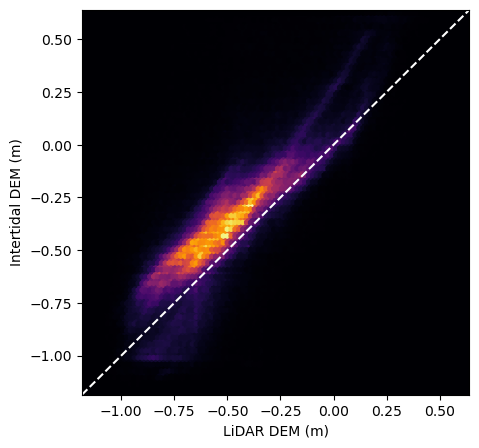

In [15]:
# Preprocess
validation_z, modelled_z = preprocess_validation(modelled_ds, validation_ds, None)

# # Plot and compare - scatterplot
# plt.figure(figsize=(7, 7))
# plt.scatter(x=validation_z, y=modelled_z, s=3, alpha=0.1)
# lim_min, lim_max = np.percentile(np.concatenate([validation_z, modelled_z]), [0.5, 99.5])
# plt.xlim(lim_min - 0.2, lim_max + 0.2)
# plt.ylim(lim_min - 0.2, lim_max + 0.2)
# plt.plot([lim_min - 0.2, lim_max + 0.2], [lim_min - 0.2, lim_max + 0.2], c="red")
# plt.xlabel("LiDAR DEM (m)")
# plt.ylabel("Intertidal DEM (m)")

# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(np.concatenate([validation_z, modelled_z]), [1, 99])
lim_min -= 0.2
lim_max += 0.2
plt.hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
eval_metrics(x=validation_z, y=modelled_z, round=3)

### Compare elevation accuracy by uncertainty

                  0-0.25  0.25-0.5  0.5-0.75  0.75-1.0  1.0-10.0
Correlation        0.879     0.827     0.610     0.210    -0.070
RMSE               0.185     0.217     0.269     0.372     0.627
MAE                0.152     0.167     0.189     0.296     0.450
R-squared          0.479     0.357    -0.239    -0.631    -0.539
Bias               0.095     0.132     0.134     0.150    -0.189
Regression slope   1.119     0.934     0.710     0.179    -0.040


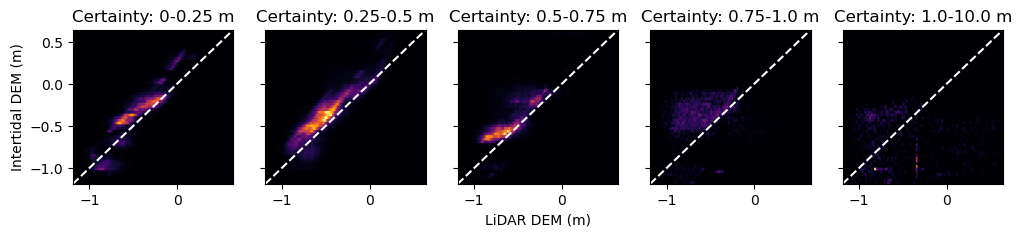

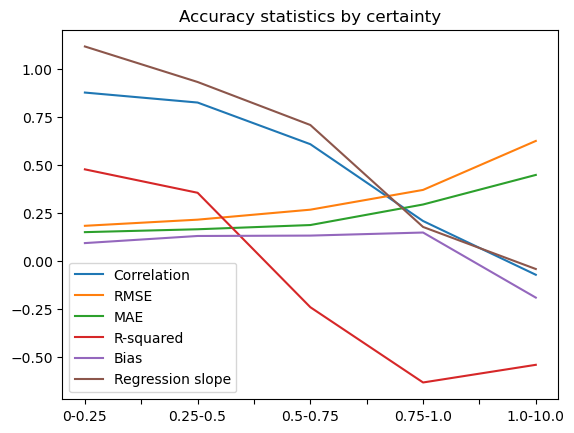

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2), sharex=True, sharey=True)

# Define a set of certainty ranges
cert_ranges = [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0), (1.0, 10.0)]

out = {}
for i, (min_thresh, max_thresh) in enumerate(cert_ranges):
    
    # Extract subset of modelled elevation according to certainty range
    modelled_ds_subset = modelled_ds.where(
        (uncertainty_ds >= min_thresh) * (uncertainty_ds < max_thresh)
    )

    # Preprocess
    validation_z, modelled_z = preprocess_validation(
        modelled_ds_subset, validation_ds, None
    )

    # Compute accuracy metrics
    certainty_str = f"{min_thresh}-{max_thresh}"
    out[certainty_str] = eval_metrics(
        x=validation_z, y=modelled_z, round=3
    )
    
    # Plot heatmaps
    axes[i].hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
    axes[i].margins(x=0, y=0)
    axes[i].set_title(f"Certainty: {certainty_str} m")
    if i == 2:
        axes[i].set_xlabel("LiDAR DEM (m)")
    if i == 0:
        axes[i].set_ylabel("Intertidal DEM (m)")

# Combine into a single dataframe
combined_df = pd.concat(out, axis=1)
combined_df.T.plot()
plt.gca().set_title("Accuracy statistics by certainty")
print(combined_df)